In [1]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_test.csv.gz", compression="gzip")


In [3]:
df.shape

(901862, 9)

In [4]:
df.head()

,full_name,asian,hispanic,nh_black,nh_white,other,total_n,race,race_code
0,Weyl Ethan,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3
1,Greenfield Jordan,0.0,0.0,0.0,1.0,0.0,2.0,nh_white,3
2,Sciancalepore Kim,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3
3,Julias Ricardo,0.0,0.0,1.0,0.0,0.0,1.0,nh_black,2
4,Volcy Besderly,0.0,0.0,1.0,0.0,0.0,1.0,nh_black,2


In [5]:
df['last_name'] = df['full_name'].apply(lambda x: x.split()[0])

In [6]:
df.head()

,full_name,asian,hispanic,nh_black,nh_white,other,total_n,race,race_code,last_name
0,Weyl Ethan,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3,Weyl
1,Greenfield Jordan,0.0,0.0,0.0,1.0,0.0,2.0,nh_white,3,Greenfield
2,Sciancalepore Kim,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3,Sciancalepore
3,Julias Ricardo,0.0,0.0,1.0,0.0,0.0,1.0,nh_black,2,Julias
4,Volcy Besderly,0.0,0.0,1.0,0.0,0.0,1.0,nh_black,2,Volcy


In [7]:
df.shape

(901862, 10)

In [8]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_lastname.joblib')


In [9]:
max_name = 30
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [10]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('last_name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [11]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    if len(line) > max_name:
      line = line[:max_name]
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [12]:
dataset = EthniColorDataset(df, lineToTensor)

In [13]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Weyl tensor([25., 33., 53., 40., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
1 Greenfield tensor([ 9., 46., 33., 33., 42., 34., 37., 33., 40., 32., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])
2 Sciancalepore tensor([21., 31., 37., 29., 42., 31., 29., 40., 33., 44., 43., 46., 33., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56.])


In [14]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [15]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 30])
1 1024 torch.Size([1024, 30])
2 1024 torch.Size([1024, 30])


In [16]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_lastname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [17]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 880/880 [00:18<00:00, 47.02it/s]


In [18]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [19]:
results_df.head()

,names,predictions
0,Grigoropoulos,3
1,Ulrey,3
2,Nacier,3
3,Lemke,3
4,Whitaker,3


In [20]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [21]:
results_df.head()

,names,predictions,preds
0,Grigoropoulos,3,nh_white
1,Ulrey,3,nh_white
2,Nacier,3,nh_white
3,Lemke,3,nh_white
4,Whitaker,3,nh_white


In [22]:
results_df.shape

(901120, 3)

In [27]:
results_df.drop_duplicates(inplace=True)
results_df.shape

(222996, 3)

In [28]:
results_df['preds'].value_counts()

nh_white    189605
hispanic     16202
nh_black     10208
asian         6269
other          712
Name: preds, dtype: int64

In [29]:
res_dict = results_df['preds'].value_counts().to_dict()

In [30]:
# prompt: Merge df and results_df based on name and names column

merged_df = df.merge(results_df, left_on='last_name', right_on='names')
merged_df.head()


,full_name,asian,hispanic,nh_black,nh_white,other,total_n,race,race_code,last_name,names,predictions,preds
0,Weyl Ethan,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3,Weyl,Weyl,3,nh_white
1,Weyl Kristen,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3,Weyl,Weyl,3,nh_white
2,Greenfield Jordan,0.0,0.0,0.0,1.0,0.0,2.0,nh_white,3,Greenfield,Greenfield,3,nh_white
3,Greenfield Todd,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3,Greenfield,Greenfield,3,nh_white
4,Greenfield Anne,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3,Greenfield,Greenfield,3,nh_white


In [31]:
print(df.shape)
print(results_df.shape)
print(merged_df.shape)

(901862, 10)
(222996, 3)
(901751, 13)


              precision    recall  f1-score   support

       asian       0.51      0.39      0.45     25752
    hispanic       0.84      0.62      0.72    163508
    nh_black       0.72      0.21      0.32    133463
    nh_white       0.73      0.96      0.83    552659
       other       0.45      0.03      0.06     26369

    accuracy                           0.74    901751
   macro avg       0.65      0.44      0.47    901751
weighted avg       0.74      0.74      0.70    901751



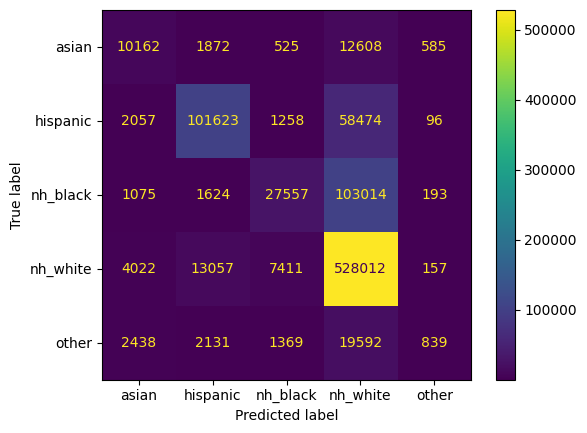

In [35]:
# prompt: Create classification report for column ethni_act and preds

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

actual = merged_df['race']
predictions = merged_df['preds']

cm = confusion_matrix(actual, predictions, labels=all_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_categories)
disp.plot(values_format="d")

print(classification_report(merged_df['race'], merged_df['preds']))

In [33]:
# accuracy for each class
correct = merged_df[merged_df['race'] == merged_df['preds']]['race'].value_counts().to_dict()
total = merged_df['race'].value_counts().to_dict()

for k, v in correct.items():
    print(f'{k}: {v/total[k]*100:.2f}%')


nh_white: 95.54%
hispanic: 62.15%
nh_black: 20.65%
asian: 39.46%
other: 3.18%
